## Restart

In [1]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)
baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})

baseball = baseball.dropna()

In [3]:
baseball['description'].value_counts()

0    85972
1    40526
Name: description, dtype: int64

## Feature Creation
1. posx + movementx, posz +movementz
2. topzone - bottom zone
3. compare to target

In [4]:
baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']

#baseball['difference_top_of_zone'] = baseball['sz_top'] - baseball['position_z']
#baseball['difference_bottom_of_zone'] = baseball['position_z'] - baseball['sz_top']
#baseball['difference_side_of_plate_x'] = baseball['']
#baseball['area_of_zone'] = 17 * baseball['height_of_zone']

In [5]:
ball_df = baseball.loc[baseball['description'] == 0]
strike_df = baseball.loc[baseball['description'] == 1]

## Downsample

use downsampling to see if results from above hold true. Will even out the classes.


In [59]:
target = 'description'
predictors = [col for col in baseball.columns if col not in [target]]


under_sampler = RandomUnderSampler(ratio = 1, random_state = 777)
baseball_down = pd.DataFrame(under_sampled[0], columns = baseball[predictors].columns)
baseball_down['description'] = under_sampled[1]

In [78]:
baseball_down['description'].value_counts()

1    40526
0    40526
Name: description, dtype: int64

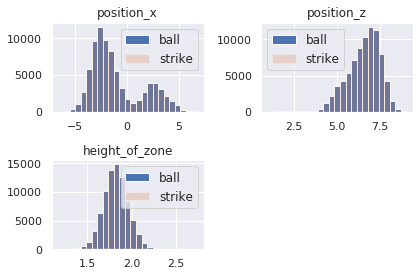

In [82]:
for idx, col in enumerate(['position_x', 'position_z', 'height_of_zone']):
    idx+=1
    plt.subplot(2,2, idx, title = col )
    plt.hist(baseball_down[col], bins = 25, label='ball')
    plt.hist(baseball_down[col], bins = 25, label = 'strike', alpha = .25)
    plt.legend(fontsize = 12)
    idx +=1
    plt.tight_layout()

In [84]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description', 'position_x',
       'position_z', 'height_of_zone', 'area_of_zone'],
      dtype='object')

## Simple Random Forest, to evaluatate new features

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split

ValueError: autodetected range of [nan, nan] is not finite

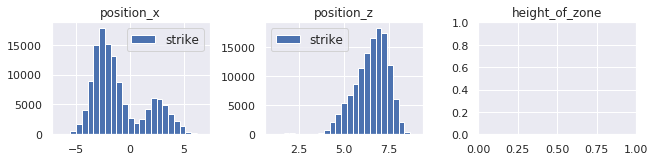

In [6]:
final_df = baseball.loc[:, ['position_x', 'position_z', 'height_of_zone', 'pitch_name', 'release_speed', 
                           'release_spin_rate', 'vx0', 'vy0', 'vz0', 'release_pos_y', 'description']]


fig = plt.figure(figsize = (12, 8))
for idx, feature in enumerate(final_df.columns):
    idx+=1
    plt.subplot(4,4, idx, title = feature )
    plt.hist(final_df[feature], bins = 25, label = 'strike')
    plt.legend(fontsize = 12)
    idx +=1
    plt.tight_layout()

In [ ]:
final_df=pd.get_dummies(final_df, prefix = 'pitch')
final_df.head()

Accuracy Score: 0.8338339920948616

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88     21552
           1       0.81      0.62      0.70     10073

    accuracy                           0.83     31625
   macro avg       0.83      0.78      0.79     31625
weighted avg       0.83      0.83      0.83     31625


 Confustion Matrix: 
 [[20114  1438]
 [ 3817  6256]]


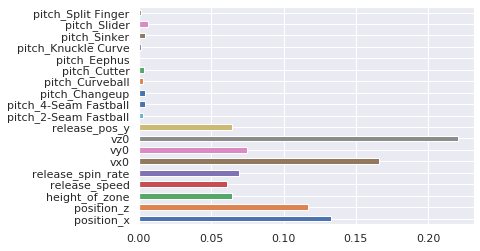

In [10]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns='description'),
                                                    final_df['description'], random_state = 777)

forest = RandomForestClassifier()


forest.fit(X_train, y_train)

pred = forest.predict(X_test)
def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(pred, y_test)

pd.Series(forest.feature_importances_, index=X_train.columns).plot(kind = 'barh')

## USE PCA

In [38]:

cv_results_lst = []
for n_components in [3,4,5,6]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    forest = RandomForestClassifier(n_estimators=10)
    
    pipe = Pipeline(steps = [
        ('pca', pca),
        ('forest', forest)
    ])
    
    cv_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =3, return_estimator=True, return_train_score = True)

    cv_results_lst.append(cv_results)
    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(cv_results[result])}")
        print(f"{result} scores: {cv_results[result]}")
        print() 
    

    


Number of Components: 3
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.9735962774267657
train_accuracy scores: [0.9728529  0.97408655 0.97384939]

Mean test_accuracy Value: 0.6445247631341516
test_accuracy scores: [0.64667194 0.64147483 0.64542752]

Mean train_f1 Value: 0.9572646966190058
train_f1 scores: [0.95599805 0.95810648 0.95768955]

Mean test_f1 Value: 0.2536961183529789
test_f1 scores: [0.25704787 0.24933792 0.25470256]

Mean train_roc_auc Value: 0.9986218963712868
train_roc_auc scores: [0.99859719 0.99865138 0.99861713]

Mean test_roc_auc Value: 0.5669157483819478
test_roc_auc scores: [0.5711324  0.56046806 0.56914679]

Number of Components: 4
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.9813171305192411
train_accuracy scores: [0.98156463 0.98097994 0.98140682]

Mean test_accuracy Value: 0.7008211001667485
test_accuracy scores: [0.70058498 0.7002593  0.70161

In [22]:
cv_results_lst[2]['estimator'][0]

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=6,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, 

In [23]:
predictions = cv_results_lst[2]['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

Accuracy Score: 0.8914150197628459

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     21552
           1       0.86      0.78      0.82     10073

    accuracy                           0.89     31625
   macro avg       0.88      0.86      0.87     31625
weighted avg       0.89      0.89      0.89     31625


 Confustion Matrix: 
 [[20290  1262]
 [ 2172  7901]]


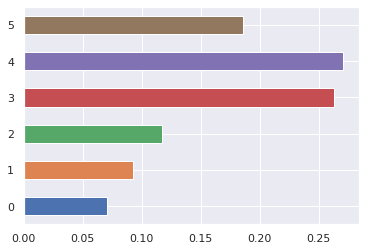

In [24]:
pd.Series(cv_results_lst[2]['estimator'][0][1].feature_importances_).plot(kind = 'barh')

In [37]:
pd.Series(cv_results_lst[2]['estimator'][0][0].explained_variance_ratio_)

0    0.998219
1    0.001228
2    0.000441
3    0.000089
4    0.000009
5    0.000005
dtype: float64